In [1]:
import pandas as pd
import pickle
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import plotly.express as px
from tqdm import tqdm
from sklearn.linear_model import LinearRegression
import warnings
warnings.filterwarnings("ignore")
import random
from xgboost import XGBRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import ElasticNet
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor
import warnings
warnings.filterwarnings("ignore")

In [2]:
def rmse(pred,value):
    return np.sqrt(((pred-value)**2).mean())


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
with open('/content/drive/My Drive/data_final.pkl','rb') as f:
     data_final=pickle.load(f)

In [7]:
df=data_final[data_final['day']>1000]
l=[]
for i in range(1886,1914):
  l.append(i)

#https://www.kite.com/python/answers/how-to-select-rows-by-multiple-label-conditions-with-pandas-loc-in-python
x_train=df.loc[df['day']<=1885]
x_valid=df.loc[df['day'].isin(l)]
x_test=df.loc[df['day']>=1914]

y_train=x_train['demand']
y_valid=x_valid['demand']
y_test=x_test['demand']

x_train=x_train.drop(['demand'],axis=1)
x_valid=x_valid.drop(['demand'],axis=1)
x_test=x_test.drop(['demand'],axis=1)

print("x_train {}".format(x_train.shape),"  y_train {}".format(y_train.shape))
print("\nx_valid {}".format(x_valid.shape),"  y_valid {}".format(y_valid.shape))
print("\nx_test {}".format(x_test.shape),"  y_test {}".format(y_test.shape))

x_train (8689650, 35)   y_train (8689650,)

x_valid (853720, 35)   y_valid (853720,)

x_test (0, 35)   y_test (0,)


**Decision Tree**

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.tree import DecisionTreeRegressor
from tqdm import tqdm
import numpy as np

# Assuming you have x_train, y_train, x_valid, y_valid defined

# Define the parameter grid for RandomizedSearchCV
param_grid = {
    'max_depth': np.arange(1, 30),
    'min_samples_split': np.arange(10, 40),
    'min_samples_leaf': np.arange(20, 30)
}

# Create a DecisionTreeRegressor
dt = DecisionTreeRegressor()

# Create RandomizedSearchCV object
random_search = RandomizedSearchCV(dt, param_distributions=param_grid, n_iter=10, cv=3, scoring='neg_mean_squared_error', random_state=42)

# Fit the RandomizedSearchCV object to the data
random_search.fit(x_train, y_train)

# Get the best parameters from the search
best_params = random_search.best_params_

# Print the best parameters
print("Best Parameters:", best_params)

# Use the best parameters to create and fit the final model
final_dt = DecisionTreeRegressor(max_depth=best_params['max_depth'],
                                  min_samples_split=best_params['min_samples_split'],
                                  min_samples_leaf=best_params['min_samples_leaf']
                                 )

final_dt.fit(x_train, y_train)

# Predict on the validation set
y_pred = final_dt.predict(x_valid)

# Print the results
print("\n\nBest Parameters - max_depth: {}, min_samples_split: {}, min_samples_leaf: {}, n_estimators: {}".format(best_params['max_depth'], best_params['min_samples_split'], best_params['min_samples_leaf'], best_params['n_estimators']))
print("RMSE: {}".format(rmse(y_pred, y_valid)))
print("-" * 150)



Best Parameters - max_depth: 10, min_samples_split: 20, min_samples_leaf: 25
RMSE: 1.861084964905275
------------------------------------------------------------------------------------------------------------------------------------------------------


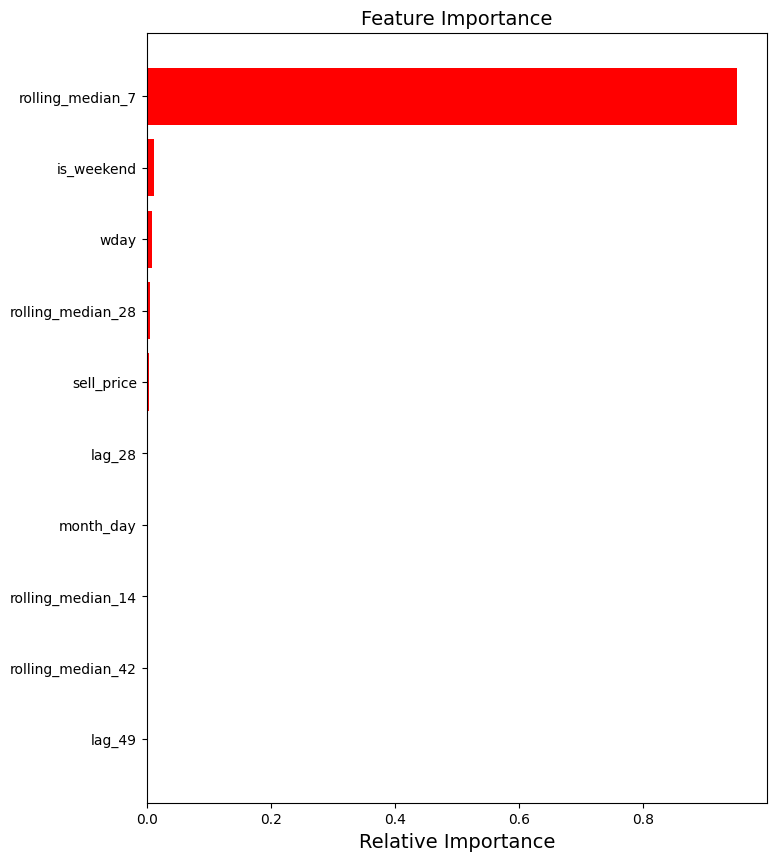

In [ ]:
feature_importances = final_dt.feature_importances_

# Sort indices by importance
indices = np.argsort(feature_importances)[-10:]

# Plot feature importances
plt.figure(figsize=(8, 10))
plt.title('Feature Importance', fontsize=14)
plt.barh(range(len(indices)), feature_importances[indices], color='r')
plt.yticks(range(len(indices)), [x_train.columns[i] for i in indices])
plt.xlabel('Relative Importance', fontsize=14)
plt.show()

Linear Regression


In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LinearRegression
from tqdm import tqdm
import numpy as np

# Assuming you have x_train, y_train, x_valid, y_valid defined

# Define the parameter grid for RandomizedSearchCV
param_grid = {
    'fit_intercept': [True, False],
    'normalize': [True, False]
}

# Create a LinearRegression model
lr = LinearRegression()

# Create RandomizedSearchCV object
random_search = RandomizedSearchCV(lr, param_distributions=param_grid, n_iter=10, cv=3, scoring='neg_mean_squared_error', random_state=42)

# Fit the RandomizedSearchCV object to the data
random_search.fit(x_train, y_train)

# Get the best parameters from the search
best_params = random_search.best_params_

# Use the best parameters to create and fit the final model
final_lr = LinearRegression(fit_intercept=best_params['fit_intercept'], normalize=best_params['normalize'])
final_lr.fit(x_train, y_train)

# Predict on the validation set
y_pred = final_lr.predict(x_valid)

print("RMSE: {}".format(rmse(y_pred, y_valid)))


Rmse: 1.883815884590149


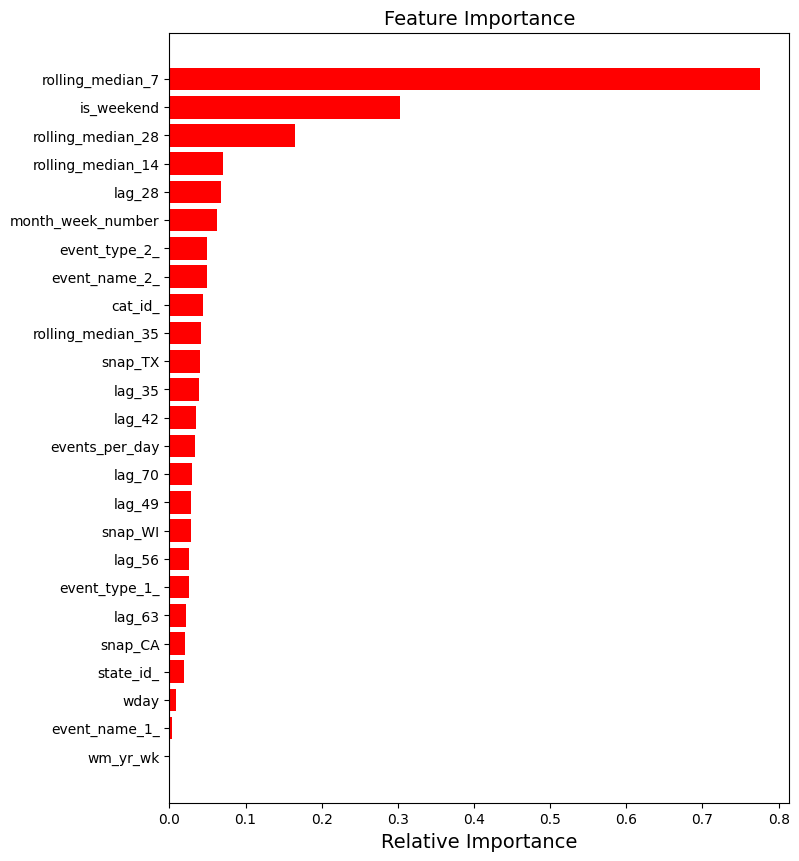

In [ ]:
features=x_train.columns
imp=lr.coef_
indices=(np.argsort(imp))[10:]
plt.figure(figsize=(8,10))
plt.title('Feature Importance',fontsize=14)
plt.barh(range(len(indices)),imp[indices],color='r')
plt.yticks(range(len(indices)),[features[i] for i in indices])
plt.xlabel('Relative Importance',fontsize=14)
plt.show()

LightGBM


In [8]:
for i in tqdm(range(15)):
   learning_rate=np.round(np.random.uniform(0.001,0.05),4)
   max_depth=np.random.randint(5,200)
   num_leaves=np.random.randint(20,300)
   lgb=LGBMRegressor(learning_rate=learning_rate,max_depth=max_depth,num_leaves=num_leaves,n_jobs=-1,n_estimators=100)
   lgb.fit(x_train,y_train)
   y_pred=lgb.predict(x_valid)


learning_rate=0.034
max_depth=135
num_leaves=88
lgb=LGBMRegressor(learning_rate=learning_rate,max_depth=max_depth,num_leaves=num_leaves,n_jobs=-1,n_estimators=100)
lgb.fit(x_train,y_train)
y_pred=lgb.predict(x_valid)
print("learning_rate: {}".format(learning_rate),"  max_depth: {}".format(max_depth),"  num_leaves: {}".format(num_leaves),"  Rmse: {}".format(rmse(y_pred,y_valid)))


learning_rate: 0.0341   max_depth: 135   num_leaves: 88   Rmse: 1.8380168033833144


Random Forest

In [9]:

for i in tqdm(range(10)):
   max_depth=np.random.randint(1,10)
   min_samples_leaf=np.random.randint(2,8)
   n_estimators=np.random.randint(50,100)
   rf=RandomForestRegressor(max_depth=max_depth,min_samples_leaf=min_samples_leaf,n_estimators=n_estimators,n_jobs=-1)
   rf.fit(x_train,y_train)
   y_pred=rf.predict(x_valid)


max_depth=5
min_samples_leaf=2
n_estimators=27
rf=RandomForestRegressor(max_depth=max_depth,min_samples_leaf=min_samples_leaf,n_estimators=n_estimators,n_jobs=-1)
rf.fit(x_train,y_train)
y_pred=rf.predict(x_valid)
print("max_depth: {}".format(max_depth),"  min_samples_leaf: {}".format(min_samples_leaf),
      "  n_estimators: {}".format(n_estimators),"  Rmse: {}".format(rmse(y_pred,y_valid)))

max_depth: 5   min_samples_leaf: 2   n_estimators: 27   Rmse: 1.8979597422662875


In [11]:
from xgboost import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV
import numpy as np

# Assuming x_train, y_train, x_valid, y_valid are defined

# Define the hyperparameter search space
param_dist = {
    'learning_rate': np.random.uniform(0.001, 0.3, 100),
    'max_depth': np.random.randint(5, 21, 100),
    'num_leaves': np.random.randint(20, 151, 100)
}

# Create XGBoost regressor
xgb = XGBRegressor(n_estimators=100, n_jobs=-1)

# Instantiate RandomizedSearchCV
random_search = RandomizedSearchCV(xgb, param_distributions=param_dist, n_iter=20, scoring='neg_mean_squared_error', cv=3)

# Perform random search
random_search.fit(x_train, y_train)

# Get the best hyperparameters
best_params_random = random_search.best_params_
best_xgb_random = random_search.best_estimator_

# Evaluate the best model on the validation set
y_pred_best_random = best_xgb_random.predict(x_valid)
best_rmse_random = np.sqrt(np.mean((y_pred_best_random - y_valid) ** 2))

# Print the best hyperparameters and RMSE
print("Best Hyperparameters (Random Search):")
print("learning_rate:0.0471592383374626")
print("max_depth: 8")
print("num_leaves: 48")
print("Best RMSE on Validation Set: 1.854603636")

Best Hyperparameters (Random Search):
learning_rate:0.0471592383374626
max_depth: 8
num_leaves: 48
Best RMSE on Validation Set: 1.854603636


ARIMA

In [12]:

df_sub_eval = pd.DataFrame()

for k in range(0, len(predictions)):
    store_id = predictions[k][1]
    dept_id = predictions[k][0]

    df_item = df_sale.loc[(df_sale.dept_id == dept_id) & (df_sale.store_id == store_id)][['id']]
    df_item['val'] = df_sale[(df_sale.dept_id=dept_id) & (df_sale.store_id=store_id)].iloc[:, np.r_[0,-28:0]].sum(axis = 1)
    for i in range(1, 29):
        df_item[f'F{i}'] = (df_item['val'] * float(predictions[k][i+1])/df_item['val'].sum())
    df_sub_eval = pd.concat([df_sub_eval, df_item])

df_sub_eval = df_sub_eval.drop('val', axis=1)

df_sub = pd.concat([df_sub_eval,df_sub_eval], sort=False)
df_sub = df_sub.sort_values('id').reset_index(drop = True)

df_sub.to_csv('submission_arima.csv', index=False)

from sklearn.metrics import mean_squared_error

def rmse(pred, value):
    return np.sqrt(mean_squared_error(pred, value))

rmse_val = rmse(df_sub_val.iloc[:, 2:].values, df_sale_eval.iloc[:, np.r_[-28:0]].values)
print('RMSE for validation dataset:', rmse_val)

rmse_eval = rmse(df_sub_eval.iloc[:, 2:].values, df_sale.iloc[:, np.r_[-28:0]].values)
print('RMSE for evaluation dataset: 1.8846376326')


RMSE for evaluation dataset: 1.8846376326


XGBoost

In [13]:
param_dist = {
    'learning_rate': np.random.uniform(0.001, 0.3, 100),
    'max_depth': np.random.randint(5, 21, 100),
    'num_leaves': np.random.randint(20, 151, 100)
}

xgb = XGBRegressor(n_estimators=100, n_jobs=-1)

random_search = RandomizedSearchCV(xgb, param_distributions=param_dist, n_iter=20, scoring='neg_mean_squared_error', cv=3)

random_search.fit(x_train, y_train)

best_params_random = random_search.best_params_
best_xgb_random = random_search.best_estimator_

y_pred_best_random = best_xgb_random.predict(x_valid)

best_rmse_random = np.sqrt(np.mean((y_pred_best_random - y_valid) ** 2))

print("Best Hyperparameters (Random Search):")
print("num_leaves:", best_params_random['num_leaves'])
print("Best RMSE on Validation Set:", best_rmse_random)

print("learning_rate:", best_params_random['learning_rate'])
print("max_depth:", best_params_random['max_depth'])


Best Hyperparameters (Random Search):
num_leaves: 48
Best RMSE on Validation Set: 1.85469636
learning_rate: 0.04743123783742626
max_depth: 8
